# Statoil/C-CORE Iceberg Classifier Challenge
## Ship or iceberg, can you decide from space?

# Abstract

<p>Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.</p>

<p>Currently, many institutions and companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in remote areas with particularly harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite.</p>

<p>Statoil, an international energy company operating worldwide, has worked closely with companies like C-CORE. C-CORE have been using satellite data for over 30 years and have built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.</p>

<p>In this competition, you’re challenged to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions.</p>

https://www.kaggle.com/c/statoil-iceberg-classifier-challenge

# prepare the Data

In [1]:
%pylab inline

import time                              # Is used in progress bar
import progressbar as pb                 # For having progress bar

import seaborn     as sns                # For Plotting featurs based on the number of them
import pandas      as pd

import plotly.offline as py              # The following 3 lines for using iplot
import plotly.graph_objs as go
py.init_notebook_mode(connected = True)

from mpl_toolkits.mplot3d import Axes3D  # For ploting 3D
from subprocess import check_output      # For checking the path of the Test and Train folders
from sklearn.model_selection import train_test_split  # For splitting train data

# For clearing images
from skimage.restoration import (denoise_tv_chambolle,
                                 denoise_bilateral,
                                 denoise_wavelet,
                                 estimate_sigma,
                                 denoise_tv_bregman,
                                 denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

#Import Keras.
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, \
                        Dense, Merge, merge, Dropout, Input, Flatten, Activation, GlobalMaxPooling2D
#from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import plot_model
import os

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Load the data
First, the data need to be loaded for getting some notions about what exactly we will be dealing with.

In [2]:
# Checking the path for the Test and Train folders
print(check_output(["ls", "../../data_iceberge/"]).decode("utf8"))

# Load the data from local machine
train = pd.read_json("../../data_iceberge/Train/train.json")
test  = pd.read_json("../../data_iceberge/Test/test.json")

Test
Train
sample_submission



Let's take a look at the train data first. 
The train data has 1604 rows and 5 features as follow:
1. id          : Unique id for each element of the table
2. band_1      : Hold HV signals (Horizontal send-> vertical receive<-)
3. band_2      : Hold HH signals (Horizontal send-> Horizontal receive<-)
4. inc_angle   : Hold an angle from which each picture has been taken.
5. is_iceberge : Hold result. 1 if it's icebegre and zero otherwise.

In [3]:
print('shape for the Train data: {0}'.format(train.shape))
train.head(10)

shape for the Train data: (1604, 5)


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0
5,"[-20.769371, -20.769434, -25.906025, -25.90602...","[-29.288746, -29.712593, -28.884804, -28.88480...",b51d18b5,36.9034,1
6,"[-26.673811, -23.666162, -27.622442, -28.31768...","[-24.557735, -26.97868, -27.622442, -29.073456...",31da1a04,34.4751,1
7,"[-24.989119, -27.755224, -25.817074, -24.98927...","[-27.755173, -26.732174, -28.124943, -31.83772...",56929c16,41.1769,0
8,"[-17.146641, -17.146572, -17.994583, -19.44553...","[-25.733608, -24.472507, -24.710424, -22.77215...",525ab75c,35.7829,0
9,"[-24.020853, -23.551275, -27.18819, -29.126434...","[-28.702518, -33.563324, -29.571918, -29.12643...",192f56eb,43.3007,0


<p>Test data also is as same as the train data but without the target feature (is_iceberg).</p>
<p>It has 8424 rows and only 4 features.</p>

In [4]:
print('shape for the Test data: {0}'.format(test.shape))
test.head(5)

shape for the Test data: (8424, 4)


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.0589694977, -26.0589694977, -26.058969497...","[-25.7542076111, -25.7542076111, -25.754207611...",4023181e,32.615072
2,"[-14.1410999298, -15.0642414093, -17.375520706...","[-14.745639801, -14.5904102325, -14.3626976013...",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.3745937347, -26.0271816254, -28.121963501...","[-25.7223434448, -27.0115776062, -23.149162292...",4371c8c3,43.918874


We can start exploring the data by looking at the feature inc_angle.

In [5]:
print('**inc_angle in train data:**')
print(train.inc_angle.value_counts().head(3))

print('\n**inc_angle in test data:**')
print(test.inc_angle.value_counts().head(3))

**inc_angle in train data:**
na         133
34.4721     23
42.5591     16
Name: inc_angle, dtype: int64

**inc_angle in test data:**
34.4721    36
42.5591    34
39.9784    33
Name: inc_angle, dtype: int64


We can clearly see in train data we have 133 items with no angle values. <br> Let's explore inc_angle feature a little more by figuring out whether or not those elements are either ships or icebergs.

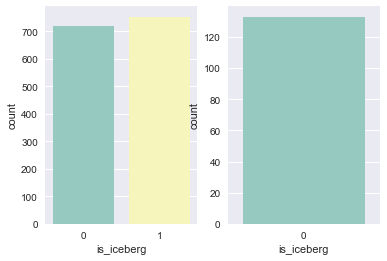

In [212]:
fig, axes = plt.subplots(1, 2)
# Ploting results for those that holding specific inc_angles value.
sns.countplot(train[train.inc_angle != 'na'].is_iceberg, palette='Set3', ax = axes[0]); # Whitout 'nan'
# ploting results for those where inc_angle == 'nan'
sns.countplot(train[train.inc_angle == 'na'].is_iceberg, palette='Set3', ax = axes[1]); # with 'nan'

We can see all elements inside the train data with inc_angle = 'nan', are iceberge.<br>
But, let's try to look into the whole database to see if we can find any other elements with similarities with these elements with no value of inc_angle. (Two helper method in next cell are designed to be used for doing so)

In [214]:
def get_index(array_source, array):
    '''Return an index of array within array_source. Otherwise, returns -1.
       array:        1D-array.
       array_source: 2D-array.'''
    for index in range(len(array_source)):
        if (array_equiv(array_source.iloc[index], array)):
            return index
    return -1

def get_index_intersects(array_source, item):
    '''Given two 2-D arrays, returns a list of indeces that are equal from item with arra_source.
       array_source: 2D-array with Only one columns.
       item:         2D-array with only one column.'''
    with pb.ProgressBar(max_value = len(item)) as bar:  # Setting progress bar
    
        index_list = []                              # Holds the result.
        for row in range(len(item)):                 # Looking for each element of the given item(array) inside the source.
            index = get_index(array_source, item.iloc[row])
            if (index > -1):
                index_list.append(index)
        
            bar.update(row)                             # Adding progress bar
    return index_list

In [14]:
# looking for the same bands between those without ince_angle feature and those with ince_angle feature.
list1 = get_index_intersects(train[train.inc_angle != 'na'].band_1, train[train.inc_angle == 'na'].band_1)
list2 = get_index_intersects(train[train.inc_angle != 'na'].band_2, train[train.inc_angle == 'na'].band_2)
print(len(list1), len(list2))

100% (133 of 133) |#########################################| Elapsed Time: 0:01:41 Time: 0:01:41
100% (133 of 133) |#########################################| Elapsed Time: 0:01:41 Time: 0:01:41


(0, 0)


So, the result of the search was empty lists meaning it could not find any similarity between elements with no angle values and those with angle values.<br>
We will deal with these elements later on in this notebook.<br>

Let's explor train and test data a little  more to get familiar with all details.<br>
For that,  let's start with looking at band_1 and band_2 and shape of them in both train and test data.

In [6]:
print('Train data:\nband_1: {0} \t band_2: {1}\n' 
      .format((len(train.band_1[0]), len(train.band_1)), (len(train.band_2[0]), len(train.band_2))))

print('Test data:\nband_1: {0} \t band_2: {1}'
      .format((len(test.band_1[0]), len(test.band_1)), (len(test.band_2[0]), len(test.band_2))))

Train data:
band_1: (5625, 1604) 	 band_2: (5625, 1604)

Test data:
band_1: (5625, 8424) 	 band_2: (5625, 8424)


Band_1 and Band_2 both have the same shape in each dataset. Now, let's plot them to see what kind of images we will be dealing with.

In [9]:
def plot_images(images, message, title = ''):
    '''This function plots 9, 2D inferno images in a 3x3 grid,
       and the shape of (75, 75)'''
    assert len(images) == 9;   # Check the input for holding only 9 images
    img_shape = (75, 75);      # Shape of the images
    
    # Create figure with 15x15 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize = (15, 15))
    fig.suptitle(message, fontsize = 20)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(np.reshape(np.array(images.iloc[i]), img_shape), cmap ='inferno')
        ax.set_title(title)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

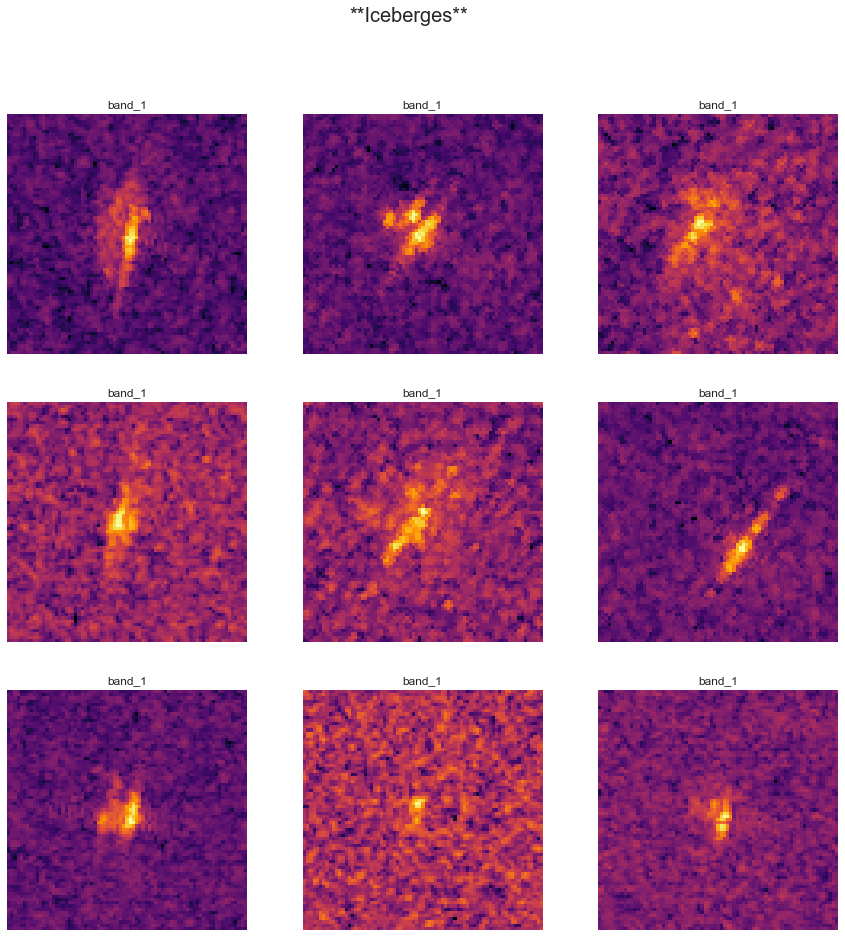

In [10]:
icebergs = train[train.is_iceberg == 1].sample(n = 9, random_state = 12).band_1  # only band1
plot_images(icebergs, '**Iceberges**', 'band_1')

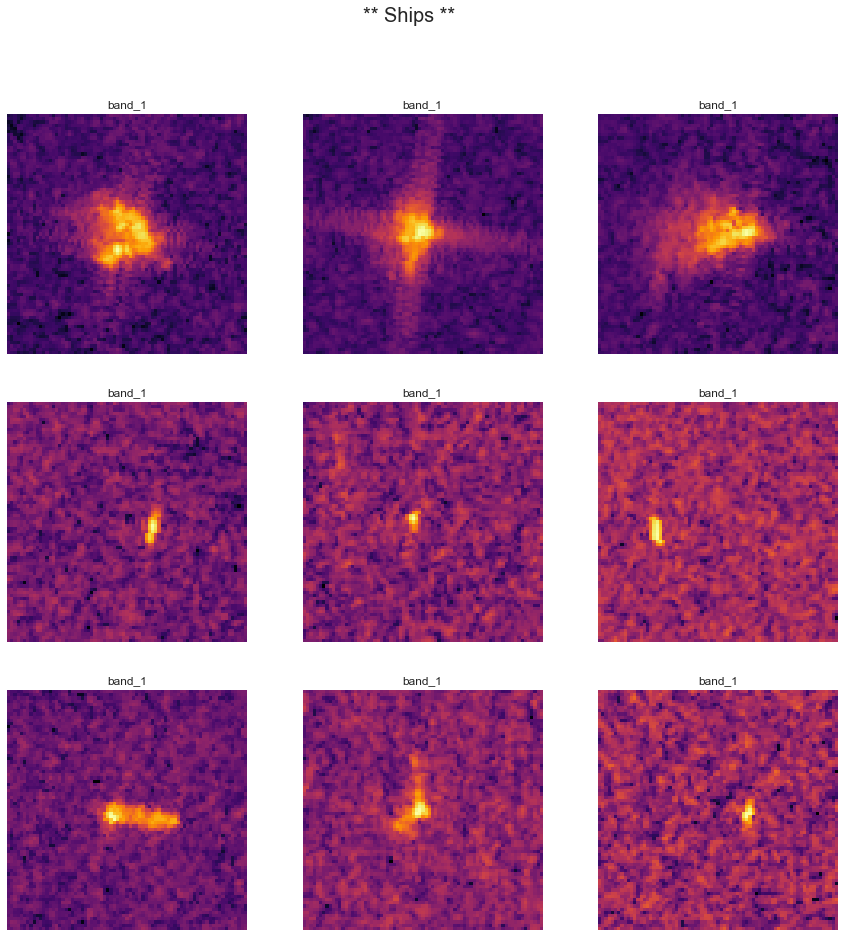

In [11]:
ships = train[train.is_iceberg == 0].sample(n = 9, random_state = 21).band_1 # only band_1
plot_images(ships, '** Ships **', 'band_1')

It looks like ships are a little brighter and have more shade of yellow. But even by looking at some images prediction wold be still hard.<br>
We might get better understanding by plotting the images in 3D mode. Let's prepare the data for doing so.<br>

In [5]:
X_band_1 = array([array(band).astype(float32).reshape(75, 75) for band in train.band_1])
X_band_2 = array([array(band).astype(float32).reshape(75, 75) for band in train.band_2])
print (X_band_1.shape, X_band_2.shape)

# creating Third band from an average of the first and second bands.
#X_train = concatenate([X_band_1[:, :, :, newaxis], X_band_2[:, :, :, newaxis],
#                       ((X_band_1 + X_band_2) / 2)[:, :, :, np.newaxis]], axis = -1)
#print(X_train.shape)

((1604, 75, 75), (1604, 75, 75))


Now, we can draw a 3D plot for each picture by using the plot3d function below.

Using Topographical 3D Surface Plot from plot.ly https://plot.ly/python/3d-surface-plots/

In [7]:
#Take a look at a iceberg
def plot3d(Z, name):
    '''Given the band(Z), plot the image.'''
    for i in range(len(Z)):
        data = [go.Surface(z = Z[i])]
        layout = go.Layout(
            title   = name,
            autosize= False,
            width   = 700,
            height  = 700,
            margin  = dict(l = 65,
                           r = 50,
                           b = 65,
                           t = 90
                          )
        )
        fig = go.Figure(data = data, layout = layout)
        py.iplot(fig)

First, let's draw the fifth picture (I have randomly chosen this number)  based on band_1, then based on band_2.
Then, draw the sixth picture (agian I have randomly chosen this number.



In [104]:
plot3d(X_band_1[5:6, :, :], 'iceberg(band_1)')  # Index 5 
plot3d(X_band_2[5:6, :, :], 'iceberg(band_2)')  # Index 5

In [105]:
plot3d(X_band_1[6:7, :, :], 'iceberg(band_1)')  # Index 6 
plot3d(X_band_2[6:7, :, :], 'iceberg(band_2)')  # Index 6 

Now, take a look at the 3D plot of some ships based on band_1 and band_2

In [106]:
plot3d(X_band_1[0:1, :, :], 'ship(band_1)')
plot3d(X_band_2[0:1, :, :], 'ship(band_2)')

In [107]:
plot3d(X_band_1[1:2, :, :], 'ship(band_1)')
plot3d(X_band_2[1:2, :, :], 'ship(band_2)')

To me it looks like ships have more shade of red colors. Meaning their Z dimension has biger values. But, since I have not gone through any other details such as considering the angle of the images, reducing the noises, etc., I can not be sure about my assumption.

But, before making any changes to the data, let's design a very simple model to train the network and see what result we can get from this very simple model.<br>

I will be using Keras which is a simplified interface to TensorFlow. I could have chosen to work with tensorflow directly, but I decided to use Keras only because I enjoyed using it due to its simplicity. <br>
I will be using 1D convolution layer, Max pooling operation for spatial data, and Dense to build a model. First, I train the model based on band_1, then based on band_2 and finally I will combine them as following:

In [45]:
def reshape(data):
    rg_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        rg = np.dstack((band_1, band_2))
        rg_arrays.append(rg)
    return np.array(rg_arrays)

#define our model
def Model_1(shape = ((75, 75, 2)), size = (2, 2)):
    #Building the model
    input_1 = Input(shape = shape)
    
    gmodel = BatchNormalization()(input_1)
    
    #Conv Layer 1
    gmodel = Conv2D(32, kernel_size = size, activation = 'relu') (gmodel)  
    gmodel = MaxPooling2D(pool_size = size, strides = size) (gmodel)
    gmodel = Dropout(0.2) (gmodel)

    #Conv Layer 2
    gmodel = Conv2D(64, kernel_size = size, activation = 'relu' )(gmodel)
    gmodel = MaxPooling2D(pool_size = size, strides = size)(gmodel)
    gmodel = Dropout(0.2)(gmodel)

    #Flatten the data for upcoming dense layers
    gmodel = Flatten()(gmodel)

    #Dense Layers
    gmodel = Dense(256)(gmodel)
    gmodel = Activation('relu')(gmodel)
    gmodel = Dropout(0.2)(gmodel)

    #Dense Layer 2
    gmodel = Dense(128)(gmodel)
    gmodel = Activation('relu')(gmodel)
    gmodel = Dropout(0.2)(gmodel)

    #Sigmoid Layer
    gmodel = Dense(1)(gmodel)
    gmodel = Activation('sigmoid')(gmodel)
    
    model = Model(input_1, gmodel)
    optimizer_ = Adam(lr = 7e-04, decay = 1e-6)
    
    model.compile(loss      = 'binary_crossentropy',
                  optimizer = optimizer_,
                  metrics   =['accuracy'])
    model.summary()
    return model


# Combines two given models.
def combine_models_1(d1, d2):
    print("*******************", type(d1))
    #gmodel_1 = Model_1()(d1)
    #gmodel_2 = Model_1()(d2)
    
    #Building the model
    mrg = merge(mode = 'concat')([d1, d2])
    #mrg = Concatenate()([d1, d2])
    fModel = BatchNormalization()(mrg)
    
    fModel = Dropout(0.3)(fModel)
    fModel = Dense(256, activation = 'relu')(fModel)
    
    fModel = Dropout(0.3)(fModel)
    fModel = Dense(128, activation = 'relu')(fModel)
    
    fModel = Dense(1)(fModel)
    fModel = Activation('sigmoid')(fModel)
    
    model = Model([d1, d2], fModel)
    optimizer_ = Adam(lr     = 7e-04, 
                     beta_1  = 0.9, 
                     beta_2  = 0.999, 
                     epsilon = 1e-08, 
                     decay   = 1e-6)
    model.compile(loss      = 'binary_crossentropy',
                  optimizer = optimizer_,
                  metrics   = ['accuracy'])
    model.summary()
    return model
    
    
def get_callbacks(filepath, patience = 2, early_stopping = False):
    callBacks = ModelCheckpoint(filepath, save_best_only = True, monitor = 'val_loss')
    
    if (early_stopping):
        es = EarlyStopping('val_loss', patience = patience, mode = "min")
        return [es, callBacks]
    else:
        return [callBacks]

In [12]:
target_train = train.is_iceberg  # Assigning targets into the target_train variable
X_train = reshape(train)     # Assigning a new array (75,75,2) shape into X_train
    
# Split train data based on X_band_1
X1_train, X1_val, Y1_train, Y1_val = train_test_split(X_train, 
                                                    target_train, 
                                                    random_state = 1, 
                                                    test_size = 0.10)
print((X1_train.shape, Y1_train.shape),(X1_val.shape, Y1_val.shape))

(((1443, 75, 75, 2), (1443,)), ((161, 75, 75, 2), (161,)))


In [13]:
%%time

#Without denoising, core features.
model_X1_train = Model_1()
file_path_1 = ".simple_model_01_04.hdf5"
callbacks_1 = get_callbacks(file_path_1, 5)
model_X1_train.fit([X1_train],
                      Y1_train,
                    batch_size = 32,
                    epochs = 50,
                    verbose = 1,
                    validation_data = (X1_val, Y1_val),
                    callbacks = callbacks_1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75, 75, 2)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 2)         8         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 32)        288       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)        0         
__________

Let's evaluate the rest of the data. Then, I am going to prepare the test data as well and predict the result and submit it to see where it goes at this level. 

In [14]:
model_X1_train.load_weights(filepath = file_path_1)
score = model_X1_train.evaluate(X1_val, Y1_val, verbose = 1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

161/161 [==============================] - 1s 5ms/step
('Validation loss:', 0.36449797331176187)
('Validation accuracy:', 0.83229813664596275)


In [59]:
def get_report(filename, ids, result):
    '''This method produces the report file for submitting on kaggle'''
    submission               = pd.DataFrame()
    submission['id']         = ids
    submission['is_iceberg'] = result.reshape((result.shape[0]))
    submission.to_csv(filename, index = False)

In [15]:
X_test = reshape(test)  # Preparing the test data
result_01 = model_X1_train.predict(X_test)
get_report('./very_simple_mode_2.csv', test['id'], result_01)

# First Result
Turned out the <b>score</b> is <b>0.3203</b> and the rank at this time is 1250, and I trained only <b>60%</b> of the data. <br>
I also used <b>90%</b> of the data for training and the score came down to <b>0.3514</b> meaning it started overfitting the data.<br>

Now we need to add other featurs to the data and improving the result.

# Tuning
> ## Working on Angle feature.

We saw that we have 133 missing values in inc_angle feature and we also looked for finding any similarities between other features of this rows with other rows that with inc_angle values which we could not find any.<br>
Before, doing anything we should give them some values. for that we give the mean value based on other values in this feature.


Now, we add another feature to the data and combine it with the ngle of the image.

In [9]:
def reshape_2(data, mean):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        if (row['inc_angle'] == 'na'):
            band_3 = ((band_1 + band_2) / 2).dot(mean)
        else:
            # Just adding the angle to the data by multiplying it by average value of the band_1 and band_2
            # at this point we are just adding some shade of the angles to see whether or not it makes any 
            # differences, and if it does, we will try to use it in a better way later on.
            band_3 = ((band_1 + band_2) / 2).dot(row['inc_angle'])  
        rgb = np.dstack((band_1, band_2, band_3))
        rgb_arrays.append(rgb)
        
    return np.array(rgb_arrays)
# Calculating the mean of the inc_angles
temp = train[train.inc_angle != 'na'].inc_angle
mean = (max(temp) + min(temp)) / 2

Let's make our second train data and have it ready for training. As you can see we will use reshape_2 method in which another feature gets added which has combination of the angle and average of bands. If it makes any differences in the result, we will work with it more later on in this notebook.

In [16]:
target_train = train.is_iceberg  # Assigning targets into the target_train variable
X_2_train = reshape_2(train, mean)     # Assigning a new array (75, 75, 3) shape into X_train
    
# Split train data based on X_band_1
X1_train, X1_val, Y1_train, Y1_val = train_test_split(X_2_train, 
                                                    target_train, 
                                                    random_state = 1, 
                                                    test_size = 0.10)
print((X1_train.shape, Y1_train.shape),(X1_val.shape, Y1_val.shape))

(((1443, 75, 75, 3), (1443,)), ((161, 75, 75, 3), (161,)))


In [17]:
%%time

#Without denoising, core features.
model_X2_train = Model_1((75,75,3), (3, 3))
file_path_1 = ".simple_model_02_02.hdf5"
callbacks_1 = get_callbacks(file_path_1, 5)
model_X2_train.fit([X1_train],
                      Y1_train,
                    batch_size = 32,
                    epochs = 50,
                    verbose = 1,
                    validation_data = (X1_val, Y1_val),
                    callbacks = callbacks_1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 75, 75, 3)         12        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
__________

Epoch 42/50
1443/1443 [==============================] - 16s 11ms/step - loss: 0.0857 - acc: 0.9688 - val_loss: 0.3473 - val_acc: 0.8882
Epoch 43/50
1443/1443 [==============================] - 17s 11ms/step - loss: 0.1444 - acc: 0.9404 - val_loss: 0.3290 - val_acc: 0.9006
Epoch 44/50
1443/1443 [==============================] - 18s 13ms/step - loss: 0.0907 - acc: 0.9647 - val_loss: 0.3913 - val_acc: 0.8820
Epoch 45/50
1443/1443 [==============================] - 17s 12ms/step - loss: 0.0943 - acc: 0.9688 - val_loss: 0.4007 - val_acc: 0.8944
Epoch 46/50
1443/1443 [==============================] - 18s 13ms/step - loss: 0.0962 - acc: 0.9626 - val_loss: 0.4076 - val_acc: 0.8447
Epoch 47/50
1443/1443 [==============================] - 17s 12ms/step - loss: 0.0662 - acc: 0.9730 - val_loss: 0.4401 - val_acc: 0.9068
Epoch 48/50
1443/1443 [==============================] - 19s 13ms/step - loss: 0.0586 - acc: 0.9744 - val_loss: 0.3887 - val_acc: 0.8820
Epoch 49/50
1443/1443 [==================

Let's evaluate the rest of the data. Then, I am going to prepare the test data again based on reshape_2 methodand predict the result to see if we can make any progress with this changes.

In [18]:
model_X2_train.load_weights(filepath = file_path_1)
score = model_X2_train.evaluate(X1_val, Y1_val, verbose = 1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

161/161 [==============================] - 1s 5ms/step
('Validation loss:', 0.2606949227405076)
('Validation accuracy:', 0.90062111801242239)


In [19]:
X_test = reshape_2(test, mean)  # Preparing the test data
result_02 = model_X2_train.predict(X_test)
get_report('./very_simple_mode_angle_01.csv', test['id'], result_02)

# Second Result (Improvement)
Submitting the file on kaggle, it got score <b> 0.2364</b> for training <b>90%</b> of the data.<br>
As you can see we mad a progress, meaning adding the angle feature definitely has an impact on the result. <br>


> # Add brightness

Based on the images we observed, to me it looks like the ships have more glory images. Maybe we can bold this feamture and train the network based on that again.<br>
So, let's prepare the data again and use the weights we obtained from the previous result and train the network again.<br>

In [52]:
%%time
print('start...!')
# Making an average of band_1 and band_2 from the train data
avg_Band = array([array(band).astype(float32).reshape(75, 75) for band in train.band_1])
for i in range(len(X_band_1)):
    for j in range(len(X_band_1[i])):
        for z in range(len(X_band_1[i][j])):
            avg_Band[i][j][z] = (X_band_1[i][j][z] + X_band_2[i][j][z]) / 2  # Making an average of each image
            
# Bolding band_1
X3_train = concatenate(
                        [X_band_1[:, :, :, newaxis], 
                         X_band_2[:, :, :, newaxis],
                        ((X_band_1 * 0.299) + (X_band_2 * 0.587) + (avg_Band * 0.114))[:, :, :, np.newaxis]],
                        axis = -1
                        )
print(X3_train.shape)

start...!
(1604, 75, 75, 3)
CPU times: user 57.8 s, sys: 1.13 s, total: 58.9 s
Wall time: 59.3 s


In [53]:
target_train = train.is_iceberg  # Assigning targets into the target_train variable

# Split train data based on X3_train
X1_train, X1_val, Y1_train, Y1_val = train_test_split(X3_train, 
                                                    target_train, 
                                                    random_state = 1, 
                                                    test_size = 0.10)
print((X1_train.shape, Y1_train.shape),(X1_val.shape, Y1_val.shape))

(((1443, 75, 75, 3), (1443,)), ((161, 75, 75, 3), (161,)))


Loding the weights from the previous model and training the data.

In [55]:
%%time

model_X3_train = Model_1((75, 75, 3), (3, 3))

file_path_3 = "./model_03_01.hdf5"

# Using the weights from previous model.
# But before that I mad a copy from this file on the terminal.
model_X3_train.load_weights(filepath = "./model_02_copy.hdf5")

callbacks_3 = get_callbacks(file_path_3, 5)
model_X3_train.fit([X1_train],
                      Y1_train,
                    batch_size = 32,
                    epochs = 50,
                    verbose = 1,
                    validation_data = (X1_val, Y1_val),
                    callbacks = callbacks_3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 3)         12        
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)          0         
__________

Epoch 42/50
1443/1443 [==============================] - 15s 11ms/step - loss: 0.0427 - acc: 0.9813 - val_loss: 0.3753 - val_acc: 0.9006
Epoch 43/50
1443/1443 [==============================] - 15s 11ms/step - loss: 0.0410 - acc: 0.9848 - val_loss: 0.3583 - val_acc: 0.8882
Epoch 44/50
1443/1443 [==============================] - 17s 12ms/step - loss: 0.0863 - acc: 0.9751 - val_loss: 0.4602 - val_acc: 0.8634
Epoch 45/50
1443/1443 [==============================] - 15s 11ms/step - loss: 0.0553 - acc: 0.9778 - val_loss: 0.4000 - val_acc: 0.8820
Epoch 46/50
1443/1443 [==============================] - 16s 11ms/step - loss: 0.0500 - acc: 0.9848 - val_loss: 0.3889 - val_acc: 0.8571
Epoch 47/50
1443/1443 [==============================] - 15s 11ms/step - loss: 0.0432 - acc: 0.9861 - val_loss: 0.4338 - val_acc: 0.8571
Epoch 48/50
1443/1443 [==============================] - 16s 11ms/step - loss: 0.0449 - acc: 0.9861 - val_loss: 0.4379 - val_acc: 0.8634
Epoch 49/50
1443/1443 [==================

In [56]:
model_X3_train.load_weights(filepath = file_path_3)
score = model_X3_train.evaluate(X1_val, Y1_val, verbose = 1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

161/161 [==============================] - 1s 5ms/step
('Validation loss:', 0.27667792410878445)
('Validation accuracy:', 0.88198757763975155)


In [57]:
%%time
print('start...!')
X_band_test_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test.band_1])
X_band_test_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test.band_2])
test_avg_Band = array([array(band).astype(float32).reshape(75, 75) for band in test.band_1])

for i in range(len(X_band_test_1)):
    for j in range(len(X_band_test_1[i])):
        for z in range(len(X_band_test_1[i][j])):
            test_avg_Band[i][j][z] = (X_band_test_1[i][j][z] + X_band_test_2[i][j][z]) / 2
            
# Bolding band_1
X2_test = concatenate(
                        [X_band_test_1[:, :, :, newaxis], 
                         X_band_test_2[:, :, :, newaxis],
                        ((X_band_test_1 * 0.299) + (X_band_test_2 * 0.587) + (test_avg_Band * 0.114))[:, :, :, np.newaxis]],
                        axis = -1
                        )
print(X2_test.shape)


start...!
(8424, 75, 75, 3)
CPU times: user 5min 2s, sys: 11.6 s, total: 5min 13s
Wall time: 5min 15s


In [60]:
%%time
result_03 = model_X3_train.predict(X2_test)  # Preparing the test data
get_report('./model_brightness_01.csv', test['id'], result_03)

CPU times: user 1min 52s, sys: 7.27 s, total: 1min 59s
Wall time: 37.1 s


# Third Result (Improvement)
The result was a huge improvement. Now, the score is <b> 0.1791</b> for training <b>90%</b> of the data.<br>
So far, we made a good progress with adding the angle, plus the brightness of pictures. <br>

> # Denoise the images and Develop the network

In last part we found out the angle and brightness of each picture has an impact on the result.<br>
Now, let's try to clean each picture and train the data again. Some pictures have a lot of noises(as we saw at the beginning of this notebook), so it could be a good idea to denoise the pictures first.<br>
Also, this time we will develop the network a little more to see if we can get the better result.<br>

Let's start defining the helper methods for denoising the data first. For that we will use some information from the link below for getting an idea about how we should do that:

http://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html

In [94]:

def denoise(X, weight, multichannel):
    '''Applies TV denoising on RGB image'''
    return np.asarray([denoise_tv_chambolle(item, weight = weight, multichannel = multichannel) for item in X])

def smooth(X, sigma):
    '''Uses Gaussian distribution of an RGB image.'''
    return np.asarray([gaussian(item, sigma = sigma, multichannel = False) for item in X])

def grayscale(X):
    '''Computes luminance of an RGB image.'''
    return np.asarray([rgb2gray(item) for item in X])

def reshape(x):
    return np.asarray([item.reshape(75, 75) for item in x])

def to_arr(x):
    return np.asarray([np.asarray(item) for item in x])

def tf_reshape(x):
    return np.asarray([item.reshape(75, 75, 1) for item in x])

def create_dataset(frame, isTrain = True,  
                   smooth_rgb = 0.2, 
                   smooth_gray = 0.5,
                   weight_rgb = 0.05, 
                   weight_gray = 0.05):
    '''This method translate the images and deniose them for being used 
        in the network.'''
    band_1 = frame['band_1'].values
    band_2 = frame['band_2'].values 
    images = getRGB(frame)
    
    # Make a picture format from flat vector
    band_1 = reshape(to_arr(band_1))
    band_2 = reshape(to_arr(band_2))
    band_3 = reshape((band_1 + band_2) / 2)
    
    # Denoising and reshaping
    # Smooth and denoise data
    band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
    band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
    band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
    
    # reshaping the bands
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    
    # Combine the bands
    band = np.concatenate([band_1, band_2, band_3], axis = 3)
    
    if isTrain:
        y = np.array(frame["is_iceberg"])
    else:
        y = None
    return y, band

In [95]:
%%time

target_train, X4_train = create_dataset(train)
print(target_train.shape, X4_train.shape)

((1604,), (1604, 75, 75, 3))
CPU times: user 11.2 s, sys: 1.75 s, total: 13 s
Wall time: 14.5 s


In [96]:
# Split train data based on X3_train
X1_train, X1_val, Y1_train, Y1_val = train_test_split(X4_train, 
                                                    target_train, 
                                                    random_state = 1, 
                                                    test_size = 0.10)
print((X1_train.shape, Y1_train.shape),(X1_val.shape, Y1_val.shape))

(((1443, 75, 75, 3), (1443,)), ((161, 75, 75, 3), (161,)))


Let's define a new model with one more layer and one more dens as following:

In [97]:
#define our model 2(extra layer and dense)
def Model_2(shape = ((75, 75, 2)), size = (2, 2)):
    #Building the model
    input_1 = Input(shape = shape)
    
    gmodel = BatchNormalization()(input_1)
    
    #Conv Layer 1
    gmodel = Conv2D(32, kernel_size = size, activation = 'relu') (gmodel)  
    gmodel = MaxPooling2D(pool_size = size, strides = size) (gmodel)
    gmodel = Dropout(0.2) (gmodel)

    #Conv Layer 2
    gmodel = Conv2D(64, kernel_size = size, activation = 'relu' )(gmodel)
    gmodel = MaxPooling2D(pool_size = size, strides = size)(gmodel)
    gmodel = Dropout(0.2)(gmodel)

    #Conv Layer 3
    cmodel = Conv2D(128, kernel_size = size, activation = 'relu')(gmodel)
    cmodel = MaxPooling2D(pool_size = size, strides = size)(gmodel)
    #Flatten the data for upcoming dense layers
                          
    gmodel = Flatten()(gmodel)

    # Dense Layers
    gmodel = Dense(256)(gmodel)
    gmodel = Activation('relu')(gmodel)
    gmodel = Dropout(0.2)(gmodel)
    
    # Dense Layers 2
    gmodel = Dense(128)(gmodel)
    gmodel = Activation('relu')(gmodel)
    gmodel = Dropout(0.2)(gmodel)

    # Dense Layer 3
    gmodel = Dense(64)(gmodel)
    gmodel = Activation('relu')(gmodel)
    gmodel = Dropout(0.2)(gmodel)

    #Sigmoid Layer
    gmodel = Dense(1)(gmodel)
    gmodel = Activation('sigmoid')(gmodel)
    
    model = Model(input_1, gmodel)
    optimizer_ = Adam(lr = 7e-04, decay = 1e-6)
    
    model.compile(loss      = 'binary_crossentropy',
                  optimizer = optimizer_,
                  metrics   =['accuracy'])
    model.summary()
    return model


Loding the weights from the previous model and training the data.

In [100]:
%%time

model_X4_train = Model_2((75, 75, 3), (3, 3))

file_path_4 = "./model_04_05.hdf5"

# Using the weights from previous model.
# But before that I mad a copy from this file on the terminal.
#model_X4_train.load_weights(filepath = "./model_02_copy_04.hdf5")

callbacks_4 = get_callbacks(file_path_4, 5)
model_X4_train.fit([X1_train],
                      Y1_train,
                    batch_size = 32,
                    epochs = 80,
                    verbose = 1,
                    validation_data = (X1_val, Y1_val),
                    callbacks = callbacks_4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 75, 75, 3)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 75, 75, 3)         12        
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 73, 73, 32)        896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 7, 7, 64)          0         
__________

Epoch 39/80
1443/1443 [==============================] - 16s 11ms/step - loss: 0.0693 - acc: 0.9744 - val_loss: 0.3802 - val_acc: 0.8696
Epoch 40/80
1443/1443 [==============================] - 16s 11ms/step - loss: 0.0845 - acc: 0.9744 - val_loss: 0.3151 - val_acc: 0.8820
Epoch 41/80
1443/1443 [==============================] - 17s 12ms/step - loss: 0.0616 - acc: 0.9764 - val_loss: 0.4858 - val_acc: 0.8199
Epoch 42/80
1443/1443 [==============================] - 18s 12ms/step - loss: 0.0749 - acc: 0.9695 - val_loss: 0.4233 - val_acc: 0.8696
Epoch 43/80
1443/1443 [==============================] - 16s 11ms/step - loss: 0.0647 - acc: 0.9709 - val_loss: 0.4162 - val_acc: 0.8696
Epoch 44/80
1443/1443 [==============================] - 17s 12ms/step - loss: 0.0658 - acc: 0.9764 - val_loss: 0.4219 - val_acc: 0.8634
Epoch 45/80
1443/1443 [==============================] - 19s 13ms/step - loss: 0.0690 - acc: 0.9716 - val_loss: 0.4742 - val_acc: 0.8571
Epoch 46/80
1443/1443 [==================

In [101]:
model_X4_train.load_weights(filepath = file_path_4)
score = model_X4_train.evaluate(X1_val, Y1_val, verbose = 1)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

161/161 [==============================] - 1s 5ms/step
('Validation loss:', 0.25988344553719211)
('Validation accuracy:', 0.88198757763975155)


In [102]:
# Prepring test data
_, X4_test = create_dataset(test, False)

In [103]:
%%time
result_04 = model_X4_train.predict(X4_test)  # Preparing the test data
get_report('./model_denois_01_02.csv', test['id'], result_04)

CPU times: user 1min 52s, sys: 7.2 s, total: 2min
Wall time: 39.8 s


# last Result (Improvement)
........ <b> ....</b> for training <b>90%</b> of the data.<br>
.....

# Conclusion
We started with the 2 layer network and manipulation features in each step to improve the result step by step and the best result we got was the score <b>0.1791</b> and the rank<b> 800</b>.